In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive_18sco = h5py.File("../data/archive_18sco.hdf5", 'r')
archive_sun = h5py.File("../data/archive.hdf5", 'r')

In [24]:
# wl_min = 5160
# wl_max = 5180
wl_min = 5850
wl_max = 5940

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

In [25]:
spectra_18sco = []
keys = list(archive_18sco)
for isot in keys: 
    sp = Spectrum(*archive_18sco[isot][:])
    spectra_18sco.append(sp)
    
spectra_sun = []
keys = list(archive_sun)
for isot in keys: 
    sp = Spectrum(*archive_sun[isot][:])
    spectra_sun.append(sp)

In [17]:
np.sort(spectra_sun[0].wavelength)

array([3781.14, 3781.15, 3781.16, ..., 6912.47, 6912.48, 6912.49])

(4800, 6500)

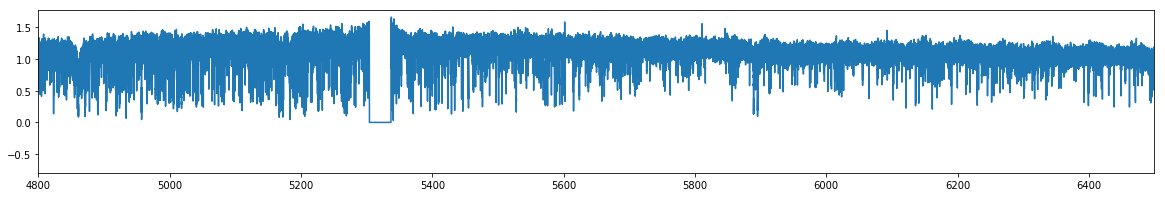

In [18]:
plt.figure(figsize=(20, 3))
plt.plot(spectra_sun[0].wavelength, spectra_sun[0].flux)
plt.xlim([4800, 6500])

In [19]:
dx_18sco = np.load('data/dx_18Sco.npy')
dx_sun = np.load('data/dx.npy')

In [26]:
coadded_18sco = spectra_18sco[0].flux

spectral_grid = spectra_18sco[0].flux 
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra_18sco[0].wavelength)))

for i in range(1, len(spectra_18sco)): 
    # Quality filter
#     if True:
    if spectra_18sco[i].flux.max() < 1.5:
        wavelength_shift = dx_18sco[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra_18sco[0].wavelength, 
                                    spectra_18sco[i].wavelength - wavelength_shift, 
                                    spectra_18sco[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        coadded_18sco += rolled_spectrum
        
coadded_18sco /= np.median(coadded_18sco)

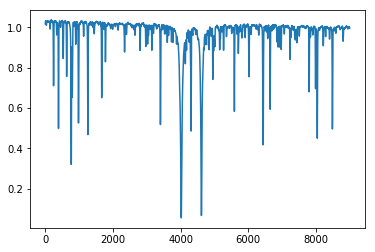

In [47]:
plt.plot(coadded_18sco)

In [48]:
coadded_sun = spectra_sun[0].flux

spectral_grid = spectra_sun[0].flux 

delta_wavelength = np.median(np.abs(np.diff(spectra_sun[0].wavelength)))

for i in range(1, len(spectra_sun)): 
    # Quality filter
#     if True:
    if spectra_sun[i].flux.max() < 1.5:
        wavelength_shift = dx_sun[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra_sun[0].wavelength, 
                                    spectra_sun[i].wavelength - wavelength_shift, 
                                    spectra_sun[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        coadded_sun += rolled_spectrum
        
coadded_sun /= np.median(coadded_sun)

In [49]:
import astropy.units as u
#Server: Vienna VALD3 Version: 1949
vald3 = open('/Users/bmmorris/git/whoseline-vis/data/vald3longer.txt').read().splitlines() # Detection threshold : 0.5

#spectral_lines = []
species = []
wavelengths = []
strengths = []
for row in vald3[4:-150]: 
    if row.count(',') > 8:
        split_row = row.split(',')

    species.append(split_row[0][1:-1].strip())
    wavelengths.append(float(split_row[1].strip())*u.Angstrom)
    strengths.append(float(split_row[9].strip()))

species = np.array(species)
wavelengths = u.Quantity(wavelengths)
strengths = np.array(strengths)

from astropy.table import Table

table = Table(dict(species=species, wavelengths=wavelengths, strengths=strengths))

def plot_lines(line_table, axis, n_lines, line_kwargs, upper_xaxis=True):
    wl_bounds = axis.get_xlim()

    rows_within_bounds = ((line_table['wavelengths'] > wl_bounds[0]) & 
                           (line_table['wavelengths'] < wl_bounds[1]))
    
    strengths_within_bounds = line_table[rows_within_bounds]['strengths']
    
    if len(strengths_within_bounds) < n_lines:
        n_lines = len(strengths_within_bounds)
    
    condition = strengths_within_bounds >= np.sort(strengths_within_bounds)[-n_lines]

    for wavelength, strength, species in zip(line_table['wavelengths'][rows_within_bounds][condition],
                                             line_table['strengths'][rows_within_bounds][condition], 
                                             line_table['species'][rows_within_bounds][condition]):
        axis.axvline(wavelength, **line_kwargs)
        if not upper_xaxis:
            axis.annotate(species, xy=(wavelength, 1.0), rotation=30)
        
    new_ticks = line_table['wavelengths'][rows_within_bounds][condition]
    new_tick_labels = line_table['species'][rows_within_bounds][condition]
    
    if upper_xaxis:
        axis_upper = axis.twiny()

        def tick_function(x):
            return (x-wl_bounds[0])/(wl_bounds[1] - wl_bounds[0])

        axis_upper.set_xticks(tick_function(new_ticks))
        axis_upper.set_xticklabels(new_tick_labels, rotation=90, ha='left', fontsize=10)

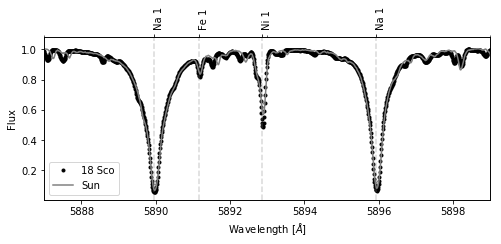

In [52]:
from matplotlib.ticker import MultipleLocator


plt.figure(figsize=(8, 3))
plt.plot(spectra_18sco[0].wavelength - 0.23, coadded_18sco, 'k.', label='18 Sco', rasterized=True)
plt.plot(spectra_sun[0].wavelength + 0.73 - 0.23, coadded_sun, color='gray', label='Sun', rasterized=True)
# plt.xlim([5160, 5178])
plt.xlim([wl_min+37, wl_max-41])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.legend()

plot_lines(table, plt.gca(), 4, dict(ls='--', color='gray', alpha=0.3))

plt.gca().xaxis.set_minor_locator(MultipleLocator(0.5))
plt.ylabel('Flux')
plt.savefig('../plots/spectra.pdf', bbox_inches='tight', dpi=300)
